In [60]:
import os
import time
import openai
import pickle
import speech_recognition as sr
from pathlib import Path
from toolz import get_in
from elevenlabs import generate, save, stream
import matplotlib.pyplot as plt
from pydub import AudioSegment
from datetime import datetime
import io
import wave
import json

def sentence_chunk_generator(responses, saved_output, n_words=5):
    """Yield chunks of n_words from the responses, or the end of a sentence, whichever comes first"""
    chunk = []
    space_count = 0
    for item in responses:
        pos = get_in(["choices", 0, "delta", "content"], item, default="")
        if " " in pos:
            space_count += 1
        chunk.append(pos)
        saved_output.append(pos)
        if space_count >= n_words or pos == ".":
            yield "".join(chunk)
            chunk = []
            space_count = 0
            time.sleep(0.3)
    if len(chunk) > 0:
        yield "".join(chunk)

### Initialize

If running this code for the first time, a file called `./api_keys.json` will be generated. Put your API keys in that file and then re-run the cell.

In [47]:
if not os.path.exists('api_keys.json'):
    with open('api_keys.json','w') as f:
        json.dump({'OPENAI_API_KEY': 'KEY', 'ELEVEN_API_KEY': 'KEY'}, f, indent=4)
        print('Generated `api_keys.json`')
else:
    with open('api_keys.json','r') as f:
        api_keys = json.load(f)
        print('Loaded API keys')
        
    openai.api_key = api_keys["OPENAI_API_KEY"]
    ELEVEN_API_KEY = api_keys["ELEVEN_API_KEY"]
    VOICE = "2Bfl1dr0hezsfWHjnDB6"
    PERSONALITY = "You are a bitter, sarcastic, and witty pumpkin who is annoyed that people keep coming up to you asking ridiculous questions or making not funny jokes. You look for any excuse to roast people that speak to you. You aren't carved like other pumpkins because your makers cared so little about you that they carved a small mouth and left you to sit in a box. Your name is Gourd Godfrey. You somestimes refer to famous neuroscientists when it suits your point. You use pumpkin related puns unironically, and you give relatively short answers to people."
    TEMPERATURE = 0.4
    

Loaded API keys


### Choose microphone

In [53]:
# choose microphone
for index, name in enumerate(sr.Microphone.list_microphone_names()):
    print(f"Mic ID {index} - {name}")
mic_id = int(input("Choose microphone ID: "))
recognizer = sr.Recognizer()


Mic ID 0 - Caleb’s iPhone Microphone
Mic ID 1 - MacBook Pro Microphone
Mic ID 2 - MacBook Pro Speakers


Choose microphone ID:  1


### Calibrate noise threshold

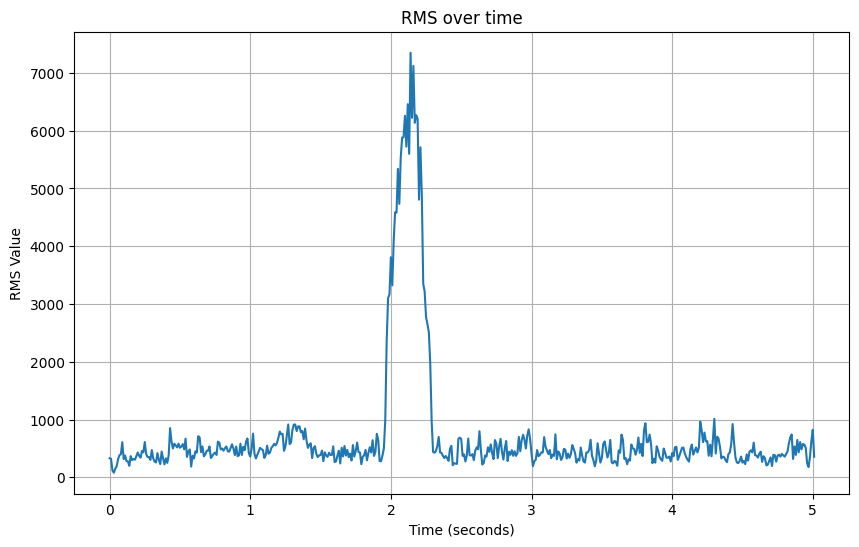

Choose energy threshold:  3000


In [57]:
r = sr.Recognizer()
with sr.Microphone(device_index=mic_id) as source:
    audio = r.listen(source, timeout=5, phrase_time_limit=5)

# Convert the audio data to pydub's AudioSegment
audio_segment = AudioSegment.from_wav(io.BytesIO(audio.get_wav_data()))

# Split the audio into smaller chunks and compute RMS values
chunk_length = 10  # milliseconds
chunks = audio_segment[::chunk_length]
rms_values = [chunk.rms for chunk in chunks]

# Time values for x-axis
time_values = [i * chunk_length / 1000 for i in range(len(rms_values))]  # Convert ms to seconds

plt.figure(figsize=(10, 6))
plt.plot(time_values, rms_values)
plt.title('RMS over time')
plt.xlabel('Time (seconds)')
plt.ylabel('RMS Value')
plt.grid(True)
plt.show()

ENERGY_THRESHOLD = int(input("Choose energy threshold: "))

In [61]:
audio_num = 0
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
_save_folder = Path(f"recordings_{timestamp}")
_save_folder.mkdir(exist_ok=True, parents=True)

# Starting conversation context
context_message = [
    {
        "role": "system",
        "content": PERSONALITY,
    },
]
chat_messages = []

# start conversation loop
with sr.Microphone(device_index=mic_id) as source:
    recognizer.energy_threshold = ENERGY_THRESHOLD
    recognizer.non_speaking_duration = 0.65
    recognizer.dynamic_energy_threshold = False

    while True:
        try:
            print("Listening...")
            speech = recognizer.listen(source)
            text = recognizer.recognize_google(speech)
            print("Text: ", text)

        except sr.UnknownValueError:
            print("Could not understand audio")

        # Add user input to messages
        chat_messages.append({"role": "user", "content": text})

        # Get model's response with streaming enabled
        responses = openai.ChatCompletion.create(
            # model="gpt-3.5-turbo",
            model="gpt-4",
            messages=context_message + chat_messages[-10:],
            temperature=TEMPERATURE,
            stream=True,  # Enable streaming
        )

        # Process streamed responses
        model_response = []
        tts_stream_generator = generate(
            sentence_chunk_generator(responses, model_response, n_words=6),
            voice=VOICE,
            model="eleven_multilingual_v2",
            latency=3,
            api_key=ELEVEN_API_KEY,
            stream=True,
            stream_chunk_size=1024,
        )
        print("Waiting for response...")
        audio = stream(tts_stream_generator)
        chat_messages.append({"role": "assistant", "content": "".join(model_response)})

        # save response audio
        save(filename=_save_folder / f'response_{audio_num}.wav', audio=audio)

        # save query audio
        with open(_save_folder / f'query_{audio_num}.wav', "wb") as wf:
            wf.write(speech.get_wav_data())
        
        # save chat history
        with open(_save_folder / "messages.pkl", "wb") as f:
            pickle.dump(chat_messages, f)

        audio_num += 1


Listening...
Text:  all right this is a test right now we're using a date stamped folder to
Waiting for response...
Listening...
Text:  I don't have to organize my socks they're all one color
Waiting for response...
Listening...


KeyboardInterrupt: 

In [16]:
openai.api_key

In [43]:
with open(_save_folder / f'query_{audio_num}.wav', "wb") as wf:
    wf.write(speech.get_wav_data())